In [1]:
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
tf.__version__

'2.0.0'

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
#train, test= tf.keras.datasets.cifar10.load_data()
# y_train = np.squeeze(y_train,axis=1)
# y_test = np.squeeze(y_test,axis=1)

In [3]:
def onehot(length, num):
    d = np.zeros(length)
    d[num] = 1
    return d

In [4]:
# y_train = np.array([onehot(10,i) for i in y_train])
# y_test = np.array([onehot(10,i) for i in y_test])

In [5]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

In [6]:
x_train = (x_train-127.5)/127.5
x_test = (x_test-127.5)/127.5

In [7]:
# train = np.array([[x_train[i],y_train[i][0]] for i in range(len(x_train))])
# for fold_num, (trn_idx, val_idx) in enumerate(fold.split(train)):
#     Train_data = train[trn_idx]
#     Train_data_x = np.array([Train_data[i][0] for i in range(len(Train_data))])
#     Train_data_y = np.array([Train_data[i][1] for i in range(len(Train_data))])
    
#     Val_data = train[val_idx]
#     Val_data_x = np.array([Val_data[i][0] for i in range(len(Val_data))])
#     Val_data_y = np.array([Val_data[i][1] for i in range(len(Val_data))])
    
#     train_ds = tf.data.Dataset.from_tensor_slices((Train_data_x, Train_data_y))
#     train_ds = train_ds.shuffle(10000).batch(64)
    
#     val_ds = tf.data.Dataset.from_tensor_slices((Val_data_x, Val_data_y))
#     val_ds = train_ds.shuffle(10000).batch(64)
    
#     print(fold_num)
#     print(Train_data.shape)

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(10000).batch(64)

In [9]:
train_ds

<BatchDataset shapes: ((None, 32, 32, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [10]:
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.shuffle(10000).batch(64)

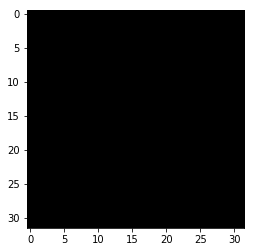

In [11]:
plt.imshow(x_train[1].astype('int16'))

In [12]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(64,3, activation='relu',strides = 1,input_shape = (32,32,3)),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding ='same', data_format='channels_last'),
#     tf.keras.layers.Flatten(input_shape=(32,32.3)),##固定輸入
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(10, activation='softmax')    
# ])

In [13]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3,activation='relu')
        self.conv22 = Conv2D(64, 5,activation='relu',padding="valid")
        self.maxpool = MaxPooling2D()
        self.drop1  = Dropout(rate = 0.3)
        self.conv2 = Conv2D(64, 3,activation='tanh')
        self.drop2  = Dropout(rate = 0.5)
        self.maxpool2 = MaxPooling2D()
        self.flatten = Flatten()
        self.d1 = Dense(2048, activation='relu')
        self.d2 = Dense(512, activation='relu')
        self.d3 = Dense(10, activation='softmax')

    def call(self, x_o): 
        #print("1: ",x.shape)
        x = self.conv1(x_o)
        x = self.conv2(x)
        x = self.drop1(x)
        
        y = self.conv22(x_o)# 28*28*32
        y = self.maxpool(y)# 14*14*32
        #print("2: ",x.shape)
        x = self.maxpool(x)
        x = self.drop1(x)# 14*14*32
        #print("3: ",x.shape)
        x = tf.concat([x, y], 3)
        
        x = self.drop2(x)
        x = self.maxpool2(x)
        #print("4: ",x.shape)
        x = self.flatten(x)
        #print("5: ",x.shape)
        x = self.d1(x)
        x = self.d2(x)
        #print("6: ",x.shape)
        return self.d3(x)

# Create an instance of the model
model = MyModel()

In [14]:
def focal_loss(logits, labels, gamma):
    '''
    :param logits:  [batch_size, n_class]
    :param labels: [batch_size]
    :return: -(1-y)^r * log(y)
    '''
    labels = tf.cast(labels, tf.int32)
    softmax = tf.reshape(tf.nn.softmax(logits), [-1])  # [batch_size * n_class]
    labels = tf.range(0, logits.shape[0]) * logits.shape[1] + labels
    prob = tf.gather(softmax, labels)
    weight = tf.pow(tf.subtract(1., prob), gamma)
    loss = -tf.reduce_mean(tf.multiply(weight, tf.log(prob)))
    return loss 

In [15]:
def multi_category_focal_loss1(y_true, y_pred):
    epsilon = 1.e-7
    gamma = 2.0
    #alpha = tf.constant([[2],[1],[1],[1],[1]], dtype=tf.float32)
    alpha = tf.constant([[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]], dtype=tf.float32)

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    y_t = tf.multiply(y_true, y_pred) + tf.multiply(1-y_true, 1-y_pred)
    ce = -tf.math.log(y_t/10)
    weight = tf.pow(tf.subtract(1., y_t), gamma)
    #print(weight)
    fl = tf.matmul(tf.multiply(weight, ce), alpha)
    loss = tf.reduce_mean(fl)
    return loss


In [16]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [17]:
def train_step(images, labels):
    #print("I :",images.shape)
    #print("L :",labels)
    with tf.GradientTape() as tape:
        predictions = model(images)
        #print("P: ",predictions.shape)
        loss = loss_object(labels, predictions)
        #print(loss)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    #print("train loss: ",loss)

In [18]:
def val_step(images, labels):
    predictions = model(images)
    loss = loss_object(labels, predictions)
    val_loss(loss)
    val_accuracy(labels, predictions)
    #print("val loss: ",loss)

In [19]:
#@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)


In [20]:
# EPOCHS = 20

# for epoch in range(EPOCHS):
#     for images, labels in train_ds:
#         train_step(images, labels)

#     for test_images, test_labels in test_ds:
#         test_step(test_images, test_labels)

#     #template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
#     print('Epoch {}/{}, Loss: {:.5f}, Accuracy: {:.5f}, Test Loss: {:.5f}, Test Accuracy: {:.5f}'.
#             format(
#                 epoch+1,
#                 EPOCHS,
#                 train_loss.result(),
#                 train_accuracy.result()*100,
#                 test_loss.result(),
#                 test_accuracy.result()*100))

#     # Reset the metrics for the next epoch
#     train_loss.reset_states()
#     train_accuracy.reset_states()
#     test_loss.reset_states()
#     test_accuracy.reset_states()


In [21]:
tf.test.is_gpu_available()

True

In [22]:
fold = KFold(n_splits = 5, random_state = 10)

In [23]:
EPOCHS = 20

train = np.array([[x_train[i],y_train[i]] for i in range(len(x_train))])
for fold_num, (trn_idx, val_idx) in enumerate(fold.split(train)):
    Train_data = train[trn_idx]
    Train_data_x = np.array([Train_data[i][0] for i in range(len(Train_data))])
    Train_data_y = np.array([Train_data[i][1] for i in range(len(Train_data))])
    
    Val_data = train[val_idx]
    #print(Train_data_x.shape)
    Val_data_x = np.array([Val_data[i][0] for i in range(len(Val_data))])
    Val_data_y = np.array([Val_data[i][1] for i in range(len(Val_data))])
    
    train_ds = tf.data.Dataset.from_tensor_slices((Train_data_x, Train_data_y))
    train_ds = train_ds.shuffle(10000).batch(64)
    
    val_ds = tf.data.Dataset.from_tensor_slices((Val_data_x, Val_data_y))
    val_ds = val_ds.shuffle(10000).batch(64)
    
    for epoch in range(EPOCHS):
        for images, labels in train_ds:
            train_step(images, labels)

        for images, labels in val_ds:
            val_step(images, labels)

        for test_images, test_labels in test_ds:
            test_step(test_images, test_labels)
            
        print('F {}/{}, Ep {}/{}, Loss: {:.5f}, Val Acc: {:.5f}, Test Loss: {:.5f}, Test Acc: {:.5f}'.
            format(
                fold_num+1,
                5,
                epoch+1,
                EPOCHS,
                train_loss.result(),
                val_accuracy.result()*100,
                test_loss.result(),
                test_accuracy.result()*100))

        # Reset the metrics for the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
    

F 1/5, Ep 1/20, Loss: 1.28018, Val Acc: 66.97000, Test Loss: 0.94791, Test Acc: 66.98000
F 1/5, Ep 2/20, Loss: 0.81581, Val Acc: 71.32000, Test Loss: 0.82028, Test Acc: 71.03001
F 1/5, Ep 3/20, Loss: 0.55958, Val Acc: 74.11000, Test Loss: 0.81661, Test Acc: 73.03000
F 1/5, Ep 4/20, Loss: 0.33353, Val Acc: 74.07000, Test Loss: 0.86996, Test Acc: 73.32000
F 1/5, Ep 5/20, Loss: 0.17276, Val Acc: 74.24000, Test Loss: 1.13422, Test Acc: 73.53000
F 1/5, Ep 6/20, Loss: 0.12097, Val Acc: 74.83000, Test Loss: 1.22659, Test Acc: 73.65000
F 1/5, Ep 7/20, Loss: 0.09192, Val Acc: 74.31000, Test Loss: 1.30473, Test Acc: 73.74000
F 1/5, Ep 8/20, Loss: 0.08449, Val Acc: 74.75000, Test Loss: 1.37619, Test Acc: 73.28000
F 1/5, Ep 9/20, Loss: 0.07003, Val Acc: 74.23000, Test Loss: 1.45415, Test Acc: 73.50999
F 1/5, Ep 10/20, Loss: 0.07435, Val Acc: 73.30000, Test Loss: 1.50365, Test Acc: 73.00999
F 1/5, Ep 11/20, Loss: 0.05891, Val Acc: 74.73000, Test Loss: 1.58918, Test Acc: 73.94000
F 1/5, Ep 12/20, Lo

F 5/5, Ep 13/20, Loss: 0.02000, Val Acc: 98.84000, Test Loss: 2.56310, Test Acc: 75.50000
F 5/5, Ep 14/20, Loss: 0.03259, Val Acc: 98.50000, Test Loss: 2.52851, Test Acc: 74.87000
F 5/5, Ep 15/20, Loss: 0.03291, Val Acc: 98.68999, Test Loss: 2.78264, Test Acc: 75.16000
F 5/5, Ep 16/20, Loss: 0.04295, Val Acc: 96.60000, Test Loss: 2.96683, Test Acc: 73.14000
F 5/5, Ep 17/20, Loss: 0.03812, Val Acc: 98.11000, Test Loss: 2.63579, Test Acc: 74.77000
F 5/5, Ep 18/20, Loss: 0.03529, Val Acc: 97.89000, Test Loss: 2.86960, Test Acc: 75.17000
F 5/5, Ep 19/20, Loss: 0.04429, Val Acc: 97.53000, Test Loss: 2.95977, Test Acc: 74.15000
F 5/5, Ep 20/20, Loss: 0.04526, Val Acc: 97.14000, Test Loss: 3.11781, Test Acc: 73.22000
